# Billiards

It is important in physics to work smart instead of hard.  Previously we used a differential equation solver to study chaos.  Here is a simpler setting to explore the same phenomena: Billiards.  A billiard is typically a two dimensional arena, in which a point particle elastically bounces off of the walls.  It turns out that there are arena shapes for which the behavior is chaotic, and others for which it is regular. 

The advantage of working with Billiards is that the particle moves at constant velocity between collisions with the walls.  It introduces a new concept in simulations:  Event driven simulation.  We do away with the ODE solver -- and analytically calculate the ball's trajectory between bounces (events).  The simulation them amounts to simply enumerating the list of events.

To see how this works, suppose a ball is at poition `(x,y)` with velocity `(vx,vy)`.  We want to find out where it will hit a horizontal wall at $y=h$.

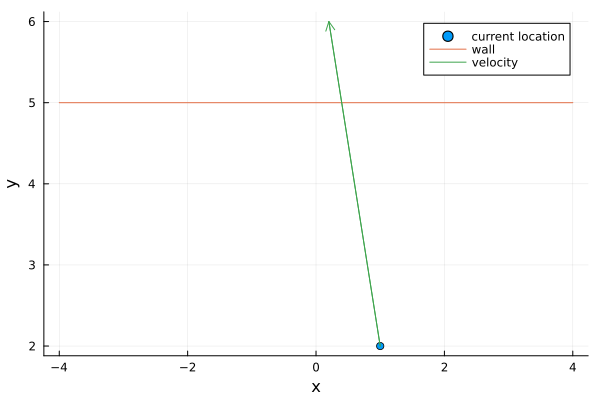

In [1]:
using Plots,Logging,ProgressMeter,LinearAlgebra
x=1;y=2;
vx=-0.8;vy=4;
h=5;
scatter((x,y),label="current location",xlabel="x",ylabel="y")
plot!([-4,4],[h,h],label="wall")
plot!([x,x+vx],[y,y+vy],arrow=true,label="velocity")

The ball will hit the wall at time $t=(h-y)/v_y$.  at the collision point, it will be at position $(x^\prime,y^\prime)=(x+ v_x t,h)$.  At the wall the $y$ velocity flips, but $v_x$ remains the same: $(v_x^\prime,v_y^\prime)=(v_x,-v_y)$.

Suppose we have a rectangular billiard.  What we will do is simply calcuate the time at which the particle will hit each of the four walls.  We choose the earliest positive time, and get the collision conditions from that wall.  We set $x,y,v_x,v_y$ accordingly, and repeat.  We end up with a discrete map.

As you see, we do not discretize time in any way.  Thus this strategy is also referred to as a "continuous time simulation".

It is convenient to make some data structures, and dive into a bit more computer science.

## Class Hierarchies and abstract types

### Billiard Class

Lets create a class which corresponds to a billiards.  It should know about where the walls are, and where the ball is.  For plotting it is also for it to know about its "bounding box" -- which is the coordinates of a rectangle which encloses the entire shape.

In [2]:
struct Billiard
    walls ::Array{Wall}
    ball ::Ball
    boundingbox # x1,y1,x2,y2 = corners of a rectangle
end

LoadError: UndefVarError: `Wall` not defined

Here we have stored the wall information as an `Array` of `Wall` objects -- which we have not yet defined.  Similarly, the information about the ball is in a `Ball` object.  Of course, we get an error message because we have not yet devied these types.

This restriction of attributes to certain types is useful, as it prevents unexpected behavior.

In [3]:
struct intcontainer
    x ::Int64
end

struct floatcontainer
    x ::Float64
end

In [4]:
i=intcontainer(2)
i.x

2

In [5]:
j=floatcontainer(2)
j.x

2.0

In [6]:
intcontainer(2.5)

LoadError: InexactError: Int64(2.5)

The other possible advantage of declaring your types inside your container objects is that it gives the compiler some extra information about how to work with them.  This can lead to faster code.  We will look more into that later in the course.  Right now the main reason for type declarations is to make the programming easier.

### Ball Class

Lets now make our `Ball` object.  It needs to store the position, velocity, and time:

In [7]:
mutable struct Ball
    x
    y
    vx
    vy
    t
end

(Again -- we could define the types of these quantities.)

We will also define some *interfaces*.  These are ways to get interact with the ball object without having to mess with how we implemented the internal structure.

In [8]:
function set_xvt!(ball ::Ball,xy,vxy,t)
    ball.x,ball.y=xy
    ball.vx,ball.vy=vxy
    ball.t=t
    return ball
end

function set_r!(ball ::Ball,x,y)
    ball.x=x
    ball.y=y
    return ball
end

function set_r!(ball ::Ball,r)
    ball.x,ball.y=r
    return ball
end

function set_v!(ball ::Ball,v)
    ball.vx,ball.vy=v
    return ball
end

function set_v!(ball ::Ball,vx,vy)
    ball.vx=vx
    ball.vy=vy
    return ball
end

function set_t!(ball::Ball,t)
    ball.t=t
    return ball
end

function get_r(ball ::Ball)
    return [ball.x,ball.y]
end

function get_v(ball ::Ball)
    return [ball.vx,ball.vy]
end

function get_t(ball ::Ball)
    return ball.t
end


get_t (generic function with 1 method)

These interfaces are not necessary, but they can be nice.  In particular, they allow a separation between how one manipulates the data, and how it is stored.

In [9]:
b1=Ball(0.,0.,1.,1.,0.)

Ball(0.0, 0.0, 1.0, 1.0, 0.0)

In [10]:
get_r(b1)

2-element Vector{Float64}:
 0.0
 0.0

In [11]:
set_r!(b1,(0.5,0.4))

Ball(0.5, 0.4, 1.0, 1.0, 0.0)

Lets add another thing to our `Ball` object -- lets make its printout a little more transparent

In [12]:
Base.show(io::IO,b::Ball)=print(io,
    "Ball << r=",repr((b.x,b.y)),
    " v=",repr((b.vx,b.vy)),
    " t=",repr(b.t)," >>")

In [13]:
b1

Ball << r=(0.5, 0.4) v=(1.0, 1.0) t=0.0 >>

In [14]:
set_t!(b1,0.4)

Ball << r=(0.5, 0.4) v=(1.0, 1.0) t=0.4 >>

A final thing is I like to add some alternative constructors

In [15]:
Ball(;x,y,vx,vy,t)=Ball(x,y,vx,vy,t) # keyword constructor
function Ball(r,v,t) # constructor using containers
    x,y=r
    vx,vy=v
    Ball(x,y,vx,vy,t)
end
Ball(;r,v,t)=Ball(r,v,t) # keyword constructor using containers

Ball

### Wall Class

Now lets make our `Wall` object.  Here we have a problem.  The description of a horizontal wall is going to be different from a vertical wall.  We may also want to create a slanted wall, or even a curved wall.  Each of these will need different storage requirements.  

The solution is to use a heirarchy of classes.  We will make a generic `Wall` class, and then make subclasses.  The generic superclass `Wall` will never actually be instantiated.  It will be what is known as an *Abstract Class* or *Abstract Type*.  It is just a label which is used to organize other types.

In [16]:
abstract type Wall end

struct Hwall <: Wall
    y
end

struct Vwall <: Wall
    x
end

One thing we might want to do with a wall is answer the question:  Given the ball's current postion and velocity, when will it hit the wall?  

In [17]:
impact_time(w::Hwall,b::Ball)=(w.y-b.y)/b.vy+b.t
impact_time(w::Vwall,b::Ball)=(w.x-b.x)/b.vx+b.t

impact_time (generic function with 2 methods)

I am bad at remembering the order in which I need to give arguments, so lets overload another signature:

In [18]:
impact_time(b::Ball,w::Wall)=impact_time(w,b)

impact_time (generic function with 3 methods)

The computer knows which object is the `Wall`, and which one is the `Ball` -- so it can assign the ball to `b` and the wall to `w`.

It may also be useful to know the distance to the wall.  We will used a signed distance, which also tells us which side of the wall we are on

In [19]:
distance(w::Hwall,b::Ball)=(w.y-b.y)
distance(w::Vwall,b::Ball)=(w.x-b.x)

distance(b::Ball,w::Wall)=distance(w,b)

distance (generic function with 3 methods)

Another thing you want to know is, where will it hit?  

At this point we can take advantage of the class heirarchy, and define one function (aka method) that works for all walls.

In [20]:
impact_location(w::Wall,b::Ball)=[b.x,b.y]+[b.vx,b.vy]*(impact_time(w,b)-b.t)

impact_location (generic function with 1 method)

Because of how we structured things, we do not need separate `impact_location` methods for `Hwall`'s and `Vwall`'s.  This greatly simplifies our code.  It also means when we are debugging or refactoring we only need to make changes in one place

In [21]:
@show b2=Ball(0.,0.,1.,2.,0.5)
impact_location(Hwall(4.),b2)

b2 = Ball(0.0, 0.0, 1.0, 2.0, 0.5) = Ball << r=(0.0, 0.0) v=(1.0, 2.0) t=0.5 >>


2-element Vector{Float64}:
 2.0
 4.0

As I said, both `Hwall` and `Vwall` now can work with `impact_location`.  This structure is sometimes referred to as *inheritance*.  The subclasses inherit properties from the superclass.

In [22]:
impact_location(Vwall(4.),b2)

2-element Vector{Float64}:
 4.0
 8.0

#### Dealing with Roundoff

Our `impact_location` function has a problem.  In exact arithmetic it will put the ball exactly on the wall.  Unfortunately, due to machine precision it will typically be a bit off.  We want to make sure the ball stays in the billiard.  If roundoff puts the ball outside the billiard it can escape.

We will deal with this in the future -- but it is good to keep in mind that it will be an issue at some point.

### Circular Walls

We could then add another wall type.  Say a circle at the origin of radius $r$.  To find the impact time we first define the initial time as $t_0=$ `b.t`, and the initial $x_0=$ `b.x`, and so on.  We would then have $x(t)=x_0+(t-t_0) v_x$ and $y(t)=y_0+(t-t_0) v_y$.  We then solve $x^2+y^2=r^2.$  This gives us a quadratic equation for $\delta t=t-t_0$.
\begin{align}
r^2&= x_0^2+y_0^2+ 2\delta t (v_x x_0+ v_y y_0) + \delta t^2 (v_x^2+v_y^2)
\end{align}
which gives
\begin{align}
\delta t&= \frac{-\vec{v}\cdot \vec{r}_0\pm\sqrt{(\vec{v}\cdot \vec{r}_0)^2-(|r_0|^2-r^2)|v|^2}}{|v|^2}.
\end{align}
There are then a number of cases:

- $|r_0|<r$ -- we are inside the circle.  There will always be two solutions, one at positive $\delta t$, and one at negative $\delta t$.  We want the one with positive $\delta t$.
- $|r_0|>r$ and $(\vec{v}\cdot \vec{r}_0)^2<4(|r_0|^2-r^2)|v|^2$.  We are outside of the circle, but moving on a trajectory which never impacts the circle -- the impact time should be infinite
- $|r_0|>r$ and $(\vec{v}\cdot \vec{r}_0)^2>4(|r_0|^2-r^2)|v|^2$.  We are outside of the circle, and the trajectory intersects the circle twice.
  - If $\vec{v}\cdot \vec{r}_0>0$ the impact times are both negative:  we can simply set the time to infinity
  - If $\vec{v}\cdot \vec{r}_0>0$ the impact times are both negative: we want the smaller one

The multiple cases are somewhat tedious.  There is a simpler approach though:
1. First calculate the discriminant $d=(\vec{v}\cdot\vec r_0)^2-(|r_0|^2-r^2)|v|^2$
    * if the discriminant is negative, the ball is never going to hit the object, so `return Inf`
2. Next calculate $\delta t_+$ and $\delta t_-$.
    * if they are both negative, return `Inf`.  Otherwise return the smallest postive time 

In [23]:
# load in package which gives us dot product x⋅y
using LinearAlgebra

In [24]:
#?dot

You can type the "dot" in $x\cdot y$ by typin `\cdot` and then hitting the tab key.

In [25]:
[1,2]⋅[4,5]

14

In [26]:
mutable struct Cwall <:Wall
    r
end

function distance(w::Cwall,b::Ball)
    r=norm(get_r(b))
    return w.r-r
end

function impact_time(w::Cwall,b::Ball)
    # Unpack variables from inputs
    t0=b.t
    r0=get_r(b)
    v=get_v(b)
    r=w.r
    # Call function which uses those inputs to calculate impact time
    t0+circ_time(r0,v,r)
end



impact_time (generic function with 4 methods)

In [27]:
function circ_time(r0,v,r)
    # Calculate the various terms in our expression
    r0dotv=r0⋅v
    vsq=v⋅v
    r0sq=r0⋅r0
    discriminant=r0dotv^2+(r^2-r0sq)*vsq  
    if discriminant<0
        return Inf
    end
    times=[(-r0dotv-sqrt(discriminant))/(vsq),(-r0dotv+sqrt(discriminant))/(vsq)]
    t1,t2=minmax(times...)
    if t2<=0 # both times are negative
        return Inf
    end
    if t1>0 # both times are positive
        return t1
    end
    return t2 # t1<0 and t2>0
end

"""
This is the tedious way to calculate the collision time with a circle
"""
function circ_time_tedious(r0,v,r)
    # Calculate the various terms in our expression
    r0dotv=r0⋅v
    vsq=v⋅v
    r0sq=r0⋅r0
    discriminant=r0dotv^2+(r^2-r0sq)*vsq
    #
    # Now lets just go through each case
    #
    # Case 1: We are inside the Circle
    if r0sq<r^2
        return (sqrt(discriminant)-r0dotv)/(vsq)
    end
    # Case 1b: We are on the circle
    if r0sq==r^2
        if r0dotv>0 #moving away
            return Inf
        else
            return -2*r0dotv/vsq
        end
    end
    # Case 2: Outside the circle, but do not hit it
    if discriminant<0
        return Inf
    end
    # Case 3: Outside, but moving away
    if r0dotv>0
        return Inf
    end
    # Case 4: Outside, and moving towards
    return (-r0dotv-sqrt(discriminant))/(vsq)
end

circ_time_tedious

In [28]:
cw1=Cwall(1.)
b1=Ball(1.5,0.,-1.,0.,0.)
il=impact_location(cw1,b1)

2-element Vector{Float64}:
 1.0
 0.0

In [29]:
il⋅il

1.0

In [30]:
impact_time(cw1,b1)

0.5

## Deciding which wall to collide off of

Now a billiard will generically have multiple walls.  Lets make a function which produces a rectangular billiard:

In [31]:
# Recall:  The Billiard class is defined as
struct Billiard
    walls ::Array{Wall}
    ball ::Ball
    boundingbox # x1,y1,x2,y2 = corners of a rectangle
end

# given the dimensions, and the coordinates of the ball, make a Billiard

function rectangular_billiard(width,height,ball_x,ball_y,ball_vx,ball_vy,ball_t)
    Billiard([Hwall(-width/2),Hwall(width/2),Vwall(-height/2),Vwall(height/2)],
        Ball(ball_x,ball_y,ball_vx,ball_vy,ball_t),
        (-width/2,-height/2,width/2,height/2))
end

# If you don't give a location/speed for the ball, just put it at the origin

rectangular_billiard(width,height)=rectangular_billiard(
    width,height,0,0,0,0,0)

rectangular_billiard(width,height,
    ball_x,ball_y,ball_vx,ball_vy)= rectangular_billiard(
    width,height,ball_x,ball_y,ball_vx,ball_vy,0)

rectangular_billiard (generic function with 3 methods)

In [32]:
billiard1=rectangular_billiard(1.,1.)

Billiard(Wall[Hwall(-0.5), Hwall(0.5), Vwall(-0.5), Vwall(0.5)], Ball << r=(0, 0) v=(0, 0) t=0 >>, (-0.5, -0.5, 0.5, 0.5))

In [33]:
billiard1.walls

4-element Vector{Wall}:
 Hwall(-0.5)
 Hwall(0.5)
 Vwall(-0.5)
 Vwall(0.5)

In [34]:
b1=billiard1.ball
set_v!(b1,[0.5,1.])
b1.t=0.5
b1

Ball << r=(0, 0) v=(0.5, 1.0) t=0.5 >>

Here is how we get all of the times for the collision of the ball with the walls

In [35]:
its=[impact_time(w,b1) for w in billiard1.walls]

4-element Vector{Float64}:
  0.0
  1.0
 -0.5
  1.5

We now want to extract the smallest time which is greater than the current time

In [36]:
"""
    argmin_abovetheshold(list,threshold)

finds the location in `list`, which contains the smallest element which is greater than `threshold`.  
Returns `0` if there is no element above `threshold`.  If there is a tie, it returns the one that 
occurs first in the list.
"""
function argmin_abovetheshold(list,threshold)
    location=0 # this will store the result
    currentmin=Inf # this will keep track of the smallest element we have found
    for i in 1:length(list)  #loop over the elements of the list
        value=list[i]
        if value>threshold && value<currentmin # The && is the logical `and`
            location=i
            currentmin=value
        end
    end
    return location
end

argmin_abovetheshold

In [37]:
argmin_abovetheshold(its,1.)

4

In [38]:
argmin_abovetheshold(its,0.5)

2

## Setting Velocity after collision

After a collision, the component of the velocity which is normal to the surface should be reversed, while the parallel component should be unchanged.

In [39]:
reflect(vec,normal)=vec-2*(vec⋅normal)*normal/(normal⋅normal)

reflect (generic function with 1 method)

In [40]:
reflect([1,2],[0,1])

2-element Vector{Float64}:
  1.0
 -2.0

So we need to extract the normal vector from our walls

In [41]:
normal(w::Hwall,r)=[0,1]
normal(w::Vwall,r)=[1,0]
normal(w::Cwall,r)=r/norm(r)

normal (generic function with 3 methods)

Now for a collision, we will first move the ball to the collision point, then calculate/set the velocity.  Here is a function which will calculate the new velocity

In [42]:
function newvelocity(w::Wall,b::Ball)
    r=get_r(b)
    n=normal(w,r)
    v=get_v(b)
    return reflect(v,n)
end

function set_newvelocity!(w::Wall,b::Ball)
    v=newvelocity(w,b)
    set_v!(b,v)
    return b
end

set_newvelocity! (generic function with 1 method)

In [43]:
function time_evolve!(b::Ball,t)
    r=get_r(b)
    v=get_v(b)
    t0=get_t(b)
    newr=r+v*(t-t0)
    set_r!(b,newr)
    set_t!(b,t)
end

# this is the naive implementation of our collide method
# -- it is vulnerable to round-off error though
function simplecollide!(b::Ball,w::Wall,t)
    start_r=get_r(b)
    time_evolve!(b,t)
    return b
end

# here is a version which deals with round-off error
function collide!(b::Ball,w::Wall,t)
    start_r=get_r(b)
    initial_distance=distance(w,b)
    time_evolve!(b,t)
    final_distance=distance(w,b) # should be zero, unless there is roundoff error
    if initial_distance*final_distance<0 # we have overshot the wall
        n=normal(w,get_r(b))
        r=get_r(b)
        v=get_v(b)
        new_r=r-v*2*abs(final_distance/(n⋅v)) # go backward along trajectory twice the amount that we have overshot
        set_r!(b,new_r)
    end
    return b
end
    
function collision_evolve!(billiard :: Billiard;teps=1e-12)
    walls=billiard.walls
    ball=billiard.ball
    collisiontimes=[impact_time(w,ball) for w in walls]
    next_collision_index=argmin_abovetheshold(collisiontimes,ball.t)
    collide!(ball,walls[next_collision_index],collisiontimes[next_collision_index]-teps)
    set_newvelocity!(walls[next_collision_index],ball)
    return billiard
end 

collision_evolve! (generic function with 1 method)

In [44]:
billiard1=rectangular_billiard(-2.,2.)
b1=billiard1.ball
set_v!(b1,(1,0.5))
collision_evolve!(billiard1;teps=0.)

Billiard(Wall[Hwall(1.0), Hwall(-1.0), Vwall(-1.0), Vwall(1.0)], Ball << r=(1.0, 0.5) v=(-1.0, 0.5) t=1.0 >>, (1.0, -1.0, -1.0, 1.0))

In [45]:
collision_evolve!(billiard1;teps=0.)

Billiard(Wall[Hwall(1.0), Hwall(-1.0), Vwall(-1.0), Vwall(1.0)], Ball << r=(0.0, 1.0) v=(-1.0, -0.5) t=2.0 >>, (1.0, -1.0, -1.0, 1.0))

In [46]:
collision_evolve!(billiard1;teps=0.)

Billiard(Wall[Hwall(1.0), Hwall(-1.0), Vwall(-1.0), Vwall(1.0)], Ball << r=(-1.0, 0.5) v=(1.0, -0.5) t=3.0 >>, (1.0, -1.0, -1.0, 1.0))

In [47]:
collision_evolve!(billiard1;teps=0.)

Billiard(Wall[Hwall(1.0), Hwall(-1.0), Vwall(-1.0), Vwall(1.0)], Ball << r=(1.0, -0.5) v=(-1.0, -0.5) t=5.0 >>, (1.0, -1.0, -1.0, 1.0))

## Main loop

Now we can write code which repeatedly has the ball bouncing off of walls until some condition is sattisfied.  That condition could be a certain number of bounces, or a time.  We could also check to see if the ball returns to its starting conditions -- in which case we have periodic motion and things will just keep repeating.

Lets make it simple, and just do a fixed number of collisions.  Lets store the date in its own object:

In [48]:
mutable struct Billiard_Simulation
    billiard ::Billiard
    events ::Array{Ball}
end

Base.length(b::Billiard_Simulation)=length(b.events)

Base.show(io::IO,b::Billiard_Simulation)=print(io,
    "Billiard_Simulation <<n="*repr(length(b))*
    " t="*repr(b.billiard.ball.t)*">>")

If we choose to store the events as an array of `Ball` objects, then we will need to create a way to copy balls:

In [49]:
Base.copy(b::Ball)=Ball(b.x,b.y,b.vx,b.vy,b.t)

In [50]:
b1=Ball(0.,0.,1.,0.,0.)

Ball << r=(0.0, 0.0) v=(1.0, 0.0) t=0.0 >>

In [51]:
b2=copy(b1)
b3=b1

Ball << r=(0.0, 0.0) v=(1.0, 0.0) t=0.0 >>

In [52]:
b2.x=5.
b1

Ball << r=(0.0, 0.0) v=(1.0, 0.0) t=0.0 >>

In [53]:
b3.y=7.
b1

Ball << r=(0.0, 7.0) v=(1.0, 0.0) t=0.0 >>

In [54]:
function simulate(b::Billiard,n::Integer)
    events=[copy(b.ball)]
    i=0
    while i<n
        collision_evolve!(b)
        push!(events,copy(b.ball))
        i+=1
    end
    return Billiard_Simulation(b,events)
end


simulate (generic function with 1 method)

In [55]:
s1=simulate(rectangular_billiard(2.,2.,0.25,0.25,1.,-1.,0),100);

In [56]:
s1

Billiard_Simulation <<n=101 t=99.24999999990115>>

In [57]:
typeof(s1.events)

Vector{Ball} (alias for Array{Ball, 1})

Writing that simulation was very easy.  Now we just need to make some visualizations.  The notation here may seem a bit complicated, but it is much simpler than what you did with the Duffing oscillator.

In [58]:
# Master function for visualizing
# -- creates new plot object, and then calls visualize!
function visualize(opts...;namedopts...)
    viz=plot()
    visualize!(viz,opts...;namedopts...)
    return viz
end

#Visualizing a Billiard Simulation
function visualize!(viz::Plots.Plot,s::Billiard_Simulation;
        walloptions=[],balloptions=[])
    visualize!(viz,s.billiard;walloptions...)
    visualize!(viz,s.events;balloptions...)
    return viz
end


function visualize!(viz::Plots.Plot,b::Billiard;opts...)
    walls=b.walls
    bbox=b.boundingbox
    for w in walls
        visualize!(viz,w,bbox;label="",opts...)
    end
    return viz
end

function visualize!(viz::Plots.Plot,w::Hwall,bbox;opts...)
    x1,y1,x2,y2=bbox
    y=w.y
    plot!(viz,[x1,x2],[y,y];opts...)
end

function visualize!(viz::Plots.Plot,w::Vwall,bbox;opts...)
    x1,y1,x2,y2=bbox
    x=w.x
    plot!(viz,[x,x],[y1,y2];opts...)
end

function visualize!(viz::Plots.Plot,w::Cwall,bbox;opts...)
    r=w.r
    xdata=[r*cos(θ) for θ in 0:2*pi/100:2*pi]
    ydata=[r*sin(θ) for θ in 0:2*pi/100:2*pi]
    plot!(viz,xdata,ydata;aspectratio=:equal,opts...)
end

function visualize!(viz::Plots.Plot,trajectory::Array{Ball};opts...)
    xdata=[b.x for b in trajectory]
    ydata=[b.y for b in trajectory]
    plot!(viz,xdata,ydata;opts...)
end

visualize! (generic function with 6 methods)

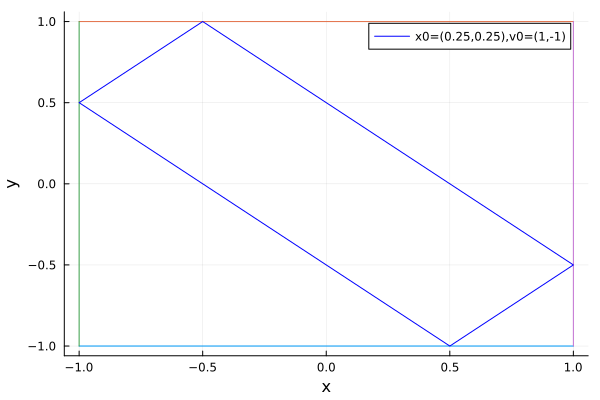

In [59]:
s1=simulate(rectangular_billiard(2.,2.,0.25,0.25,1.,-1.,0),100);
viz=visualize(s1,
    walloptions=(xlabel="x",ylabel="y"),
    balloptions=(label="x0=(0.25,0.25),v0=(1,-1)",linecolor=:blue));
display(viz)

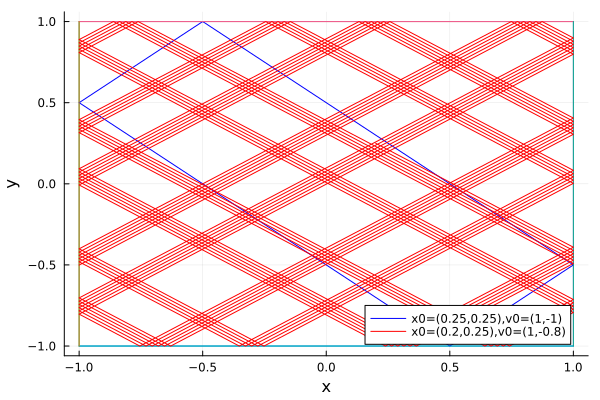

In [60]:
s2=simulate(rectangular_billiard(2.,2.,0.2,0.25,1.,-0.801,0),100);
visualize!(viz,s2,
    walloptions=(xlabel="x",ylabel="y"),
    balloptions=(label="x0=(0.2,0.25),v0=(1,-0.8)",linecolor=:red));
display(viz)

### Poincare sections

When we were looking at the driven non-linear oscillator we defined the *Poincare Section* to be a plot of phase space at some particular periodic time.  The analogous quantity for Billiards is to plot phase space at some particular *event*.  The most obvious is every time the ball hits a wall.  Given that the boundary is a line, and the magnitude of the velocity is fixed, phase space is two dimensional (when the ball is constrained to be on the boundary).  A convenient way to plot things is to use polar coordinates, and plot the direction of the velocity vs the direction of the position.

In [61]:
function poincare(s::Billiard_Simulation;opts...)
    θ=[atan(b.y,b.x) for b in s.events[2:end]]
    ϕ=[atan(b.vy,b.vx) for b in s.events[2:end]]
    scatter(θ,ϕ;xlabel="tan⁻¹(y/x)",ylabel="tan⁻¹(vy/vx)",opts...)
end

function poincare!(s::Billiard_Simulation;opts...)
    θ=[atan(b.y,b.x) for b in s.events[2:end]]
    ϕ=[atan(b.vy,b.vx) for b in s.events[2:end]]
    scatter!(θ,ϕ;xlabel="tan⁻¹(y/x)",ylabel="tan⁻¹(vy/vx)",opts...)
end

poincare! (generic function with 1 method)

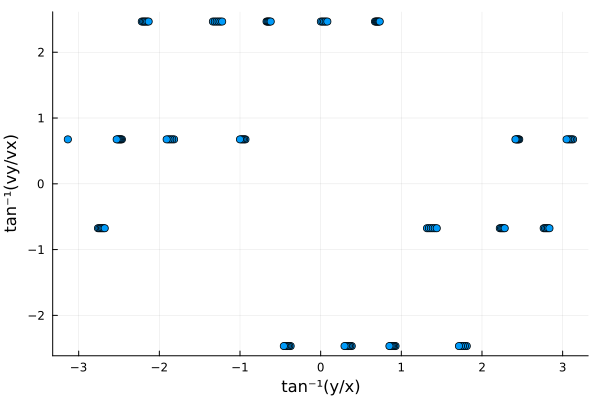

In [62]:
poincare(s2,label="")

## Animation

It is clear that we need to make some sort of animation of our data.  We could use `Plots.jl` or `GLMakie`.  Since we already loaded `Plots.jl`, lets just use it.  (Though to be honest, I prefer the GLMakie animations)

The simplest animation would simply display the trajectories event by event.  A more sophisticated one would generate a time series from the events

In [63]:
function eventanimate(s::Billiard_Simulation;traillength=10)
        # print out a message to let the user know things are starting
    @info "Animating Billiard"
    # Make a progress bar
    billiard=s.billiard
    events=s.events
    x=[b.x for b in events]
    y=[b.y for b in events]
    times=[b.t for b in events]
    progress_meter=Progress(length(times),desc="Generating frames: ")
    anim =  @animate for i in eachindex(times)
        update!(progress_meter,i)
        # Generate path
        x_path = x[1:i]
        y_path = y[1:i]
        plt=visualize(billiard)
        Plots.plot!(x_path, y_path, linecolor = :black,
            xlabel="x",ylabel="y",linewidth=0.25,label="")


        if(i>1)
            # Generate chem-trails
            x_trail=reverse(x[max(1,i-traillength):i])
            y_trail=reverse(y[max(1,i-traillength):i])
            n=length(x_trail)
            widths =range(5, 0.5, length = n)
            alpha = range(1, 0, length = n)

            Plots.plot!(x_trail,y_trail,linewidth =widths,
                seriesalpha =alpha,label=false)
        end
    
        Plots.scatter!(
            (x[i],
            y[i]),
            color = :black,
            markersize = 5,
            markerstrokewidth = 0,
            markerstrokecolor = :orange,label=""
        )
    
        Plots.annotate!(0, 0.5, "time="*string(round(times[i];digits=2)))
    end
    Plots.gif(anim, fps = 12)
end

eventanimate (generic function with 1 method)

In [ ]:
#eventanimate(s1)

In [ ]:
#eventanimate(s2)

Those actually look pretty good.  Nonetheless, if we do want to more fine-grain the motion, here is how I would extract a time series.

In [64]:
function timeseries(s::Billiard_Simulation,dt)
    events=s.events
    t=events[1].t
    x=events[1].x
    y=events[1].y
    xlist=Array{typeof(x)}(undef,0) # make an empty array
    ylist=Array{typeof(x)}(undef,0)
    times=Array{Float64}(undef,0)
    for j in 1:(length(events)-1)
        start_x=events[j].x
        start_y=events[j].y
        start_t=get_t(events[j])
        end_t=get_t(events[j+1])
        vx=events[j].vx
        vy=events[j].vy
        push!(xlist,start_x)
        push!(ylist,start_y)
        push!(times,start_t)
        while t<end_t
            x=start_x + (t-start_t)*vx
            y=start_y + (t-start_t)*vy
            push!(xlist,x)
            push!(ylist,y)
            push!(times,t)
            t+=dt
        end
    end    
    (billiard=s.billiard,x=xlist,y=ylist,times=times)
end

timeseries (generic function with 1 method)

In [65]:
# Since it takes some time to generate the frames we want to show
#  a progress bar.  This is good practice for any slow code.
using ProgressMeter

"""
    animatebilliard(billiard,x,y,times)

Generates an animation of a billiard.
"""
function animatebilliard(billiard,x,y,times;traillength=100)    
    # print out a message to let the user know things are starting
    @info "Animating Billiard"
    # Make a progress bar
    progress_meter=Progress(length(times),desc="Generating frames: ")
    # Loop to generate the frames
    # the `@animate` is a macro defined by Plots.jl
    # which takes the plot generated in each loop
    # and wraps it into an object that it knows how to 
    # make a video from
    anim =  @animate for i in eachindex(times)
        update!(progress_meter,i)
        # Generate path
        x_path = x[1:i]
        y_path = y[1:i]
        plt=visualize(billiard)
        Plots.plot!(x_path, y_path, linecolor = :black,
            xlabel="x",ylabel="y",linewidth=0.25,label="")


        if(i>1)
            # Generate chem-trails
            x_trail=reverse(x[max(1,i-traillength):i])
            y_trail=reverse(y[max(1,i-traillength):i])
            n=length(x_trail)
            widths =range(5, 0.5, length = n)
            alpha = range(1, 0, length = n)

            Plots.plot!(x_trail,y_trail,linewidth =widths,
                seriesalpha =alpha,label=false)
        end
    
        Plots.scatter!(
            (x[i],
            y[i]),
            color = :black,
            markersize = 5,
            markerstrokewidth = 0,
            markerstrokecolor = :orange,label=""
        )
    
        Plots.annotate!(0, 0.5, "time="*string(round(times[i];digits=2)))
    end
    Plots.gif(anim, fps = 24)
end 

animatebilliard

In [66]:
ts1=timeseries(s1,0.2);

In [67]:
#animatebilliard(ts1...)

In [68]:
s2=simulate(rectangular_billiard(2.,2.,0.2,0.25,1.,-0.801,0),500);
ts2=timeseries(s2,2.)
#animatebilliard(ts2...)

(billiard = Billiard(Wall[Hwall(-1.0), Hwall(1.0), Vwall(-1.0), Vwall(1.0)], Ball << r=(-0.999999999998994, -0.14479999990895376) v=(1.0, -0.801) t=554.799999999439 >>, (-1.0, -1.0, 1.0, 1.0)), x = [0.2, 0.2, 0.9999999999990001, 0.23945068664069835, -0.2000000000019998, -0.9999999999989998, 0.2000000000040002, 0.25742821473258515, 0.9999999999989996, -0.20000000000600104  …  0.20000000055379685, 0.5770287142189373, 0.9999999999989596, -0.20000000055587763, -0.999999999998994, -0.9260923844057233, 0.20000000055788958, 0.9999999999989596, 0.4292134830323958, -0.20000000055997036], y = [0.25, 0.25, -0.3907999999991991, -0.9999999999991989, -0.6479999999983976, -0.007200000000800566, 0.9540000000016025, 0.9999999999991991, 0.40520000000080114, -0.5560000000032044  …  0.6980000003534121, 0.9999999999991896, 0.6612000000893918, -0.3000000003550328, -0.9407999999089691, -0.999999999999179, -0.09799999964332506, 0.542799999908972, 0.9999999999991895, 0.49599999964170416], times = [0.0, 0.0, 0.

## Circular Billiard

In [69]:
function circular_billiard(r,ball_x,ball_y,ball_vx,ball_vy,ball_t)
    Billiard([Cwall(r)],
        Ball(ball_x,ball_y,ball_vx,ball_vy,ball_t),
        (-r,-r,r,r))
end

# If you don't give a location/speed for the ball, just put it at the origin

circular_billiard(r)=circular_billiard(
    r,0,0,0,0,0)

circular_billiard(r,
    ball_x,ball_y,ball_vx,ball_vy)= circular_billiard(
    r,ball_x,ball_y,ball_vx,ball_vy,0)

circular_billiard (generic function with 3 methods)

In [70]:
b3=circular_billiard(1.,0.5,0,0.2,0.4,0)

Billiard(Wall[Cwall(1.0)], Ball << r=(0.5, 0) v=(0.2, 0.4) t=0 >>, (-1.0, -1.0, 1.0, 1.0))

In [71]:
s3=simulate(b3,100)

Billiard_Simulation <<n=101 t=397.4999999997999>>

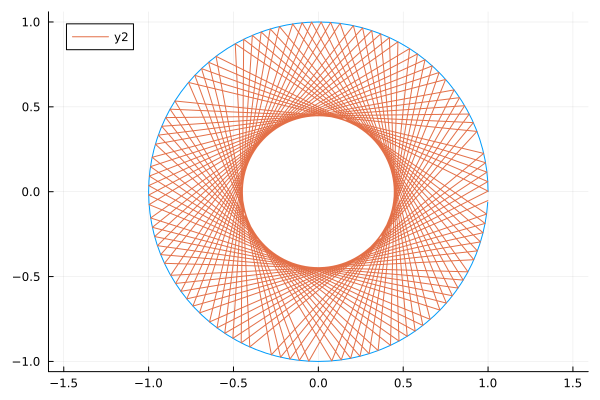

In [72]:
visualize(s3)

We see that the trajectories seem to "accumulate" on a ring.  This is referred to as a "caustic"

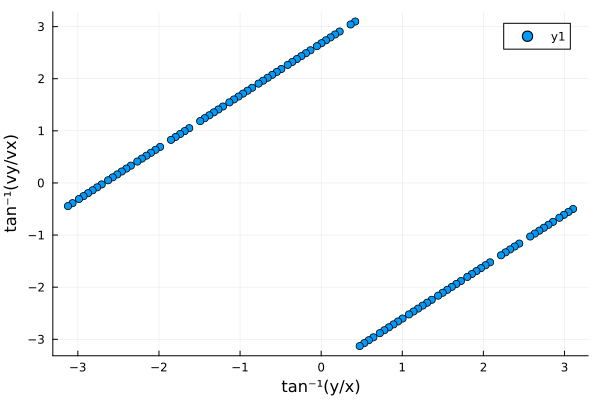

In [73]:
poincare(s3)

In [ ]:
#eventanimate(s3)

### Sinai Billiards

If we put a circular wall inside a rectangular Billiard, we get more interesting behavior

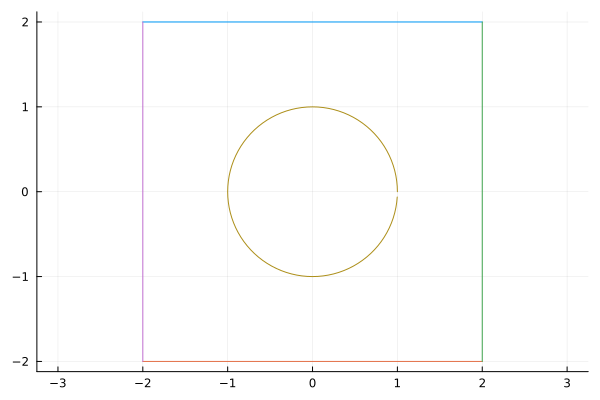

In [74]:
b_sinai= Billiard([Hwall(2),Hwall(-2),Vwall(2),Vwall(-2),Cwall(1)],
    Ball(1.5,0,1,0.5,0),[-2,-2,2,2])
visualize(b_sinai,aspectratio=:equal)

Now if we watch the ball motion, it appears chaotic

In [75]:
ss=simulate(b_sinai,500)
#eventanimate(ss)

Billiard_Simulation <<n=501 t=806.3512226613519>>

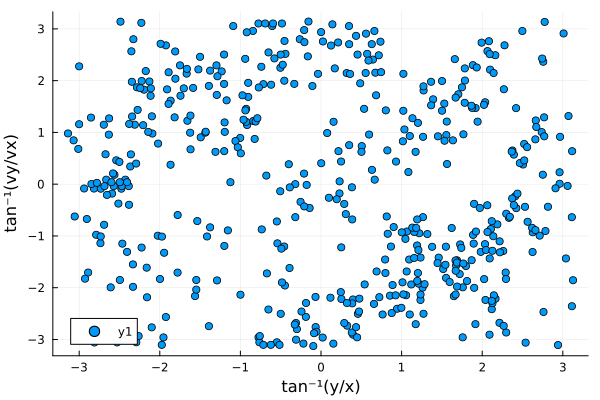

In [76]:
poincare(ss)

Lets fill that in a bit more

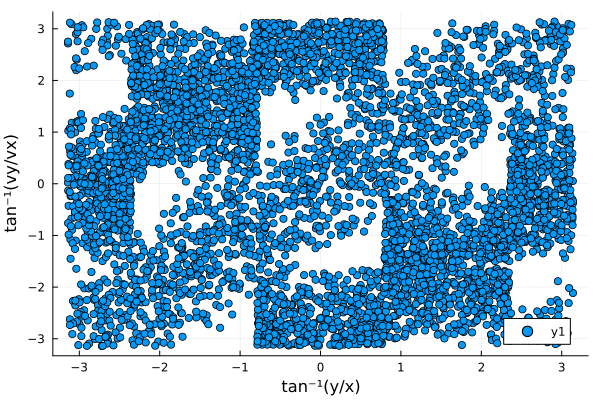

In [77]:
longss=simulate(b_sinai,5000)
poincare(longss)

Note that other initial conditions are regular

In [ ]:
b_sinai2= Billiard([Hwall(2),Hwall(-2),Vwall(2),Vwall(-2),Cwall(1)],
    Ball(1.5,0,1,1,0),[-2,-2,2,2])
ss2=simulate(b_sinai2,10)
visualize(ss2)

### Sensitive dependence on initial condidtions

As before, to explore chaos, we want to look at the Jacobian
\begin{equation}
J=\left(\begin{array}{cccc}
\frac{\partial x}{\partial x_0}&
\frac{\partial x}{\partial y_0}&
\frac{\partial x}{\partial vx_0}&
\frac{\partial x}{\partial vy_0}\\
\frac{\partial y}{\partial x_0}&
\frac{\partial y}{\partial y_0}&
\frac{\partial y}{\partial vx_0}&
\frac{\partial y}{\partial vy_0}\\
\frac{\partial vx}{\partial x_0}&
\frac{\partial vx}{\partial y_0}&
\frac{\partial vx}{\partial vx_0}&
\frac{\partial vx}{\partial vy_0}\\
\frac{\partial vy}{\partial x_0}&
\frac{\partial vy}{\partial y_0}&
\frac{\partial vy}{\partial vx_0}&
\frac{\partial vy}{\partial vy_0}\\
\end{array}\right),
\end{equation}
evaluated at the bounces.  

To find these derivatives we will use the `ForwardDiff` package

In [78]:
using ForwardDiff # load package
FD=ForwardDiff # rename package, for easy reference

ForwardDiff

We then want to make some helper routines that makes the coordinates in `ball` these dual vectors

In [79]:
function dualxv(x,y,vx,vy)
    return [FD.Dual(x,FD.Partials((1.,0.,0.,0.))),
            FD.Dual(y,FD.Partials((0.,1.,0.,0.))),
            FD.Dual(vx,FD.Partials((0.,0.,1.,0.))),
            FD.Dual(vy,FD.Partials((0.,0.,0.,1.)))]
end

function dualball(x,y,vx,vy,t)
    return Ball(dualxv(x,y,vx,vy)...,t)
end

function jac(dball)
    hcat(collect(dball.x.partials.values),
        collect(dball.y.partials.values),
        collect(dball.vx.partials.values),
        collect(dball.vy.partials.values))
end

jac (generic function with 1 method)

Here is a simple example

In [80]:
xv1=dualxv(1.,2.,3.,4.)

4-element Vector{ForwardDiff.Dual{Nothing, Float64, 4}}:
 Dual{Nothing}(1.0,1.0,0.0,0.0,0.0)
 Dual{Nothing}(2.0,0.0,1.0,0.0,0.0)
 Dual{Nothing}(3.0,0.0,0.0,1.0,0.0)
 Dual{Nothing}(4.0,0.0,0.0,0.0,1.0)

In [81]:
x1=xv1[1]
y1=xv1[2]
test=x1^2+y1^2
@show test.value
@show test.partials

test.value = 5.0
test.partials = Partials(2.0, 4.0, 0.0, 0.0)


4-element ForwardDiff.Partials{4, Float64}:
 2.0
 4.0
 0.0
 0.0

That tells us that $d(x^2+y^2)/dx$ evaluated at $x,y=(1,2)$ is $2$,  and $d(x^2+y^2)/dx$, evaluated at the same point is $4$.

Here is using the `dualball` construction -- on a rectangular billiard

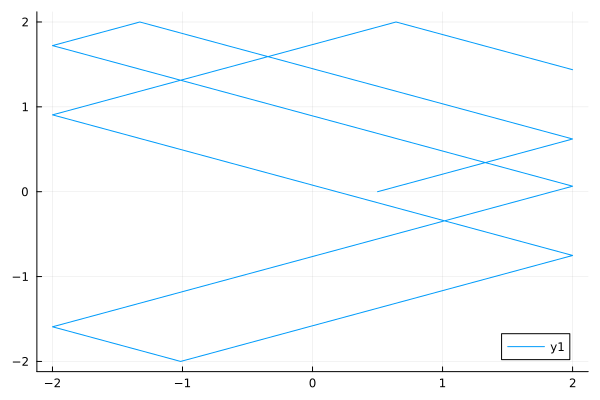

In [82]:
ball_test1=dualball(0.5,0,1.,sqrt(2)-1,0)
billiard_test1=Billiard([Hwall(2),Hwall(-2),
        Vwall(2),Vwall(-2)],ball_test1,[-2,-2,2,2])
s_test1=simulate(billiard_test1,10)
poslist=[(event.x.value,event.y.value) for event in s_test1.events]
plot(poslist)

Lets see what the Jacobian looks like.  

In [83]:
jaclist=[jac(event) for event in s_test1.events]
eiglist=[eigvals(j) for j in jaclist]

11-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0]
 [-1.0, 0.0, 1.0, 1.0]
 [-1.0, -1.0, -1.0, 0.0]
 [-1.0, -1.0, 0.0, 1.0]
 [-1.0, -1.0, -1.0, 0.0]
 [-1.0, -1.0, 0.0, 1.0]
 [0.0, 1.0, 1.0, 1.0]
 [-1.0, 0.0, 1.0, 1.0]
 [0.0, 1.0, 1.0, 1.0]
 [-1.0, 0.0, 1.0, 1.0]
 [-1.0, -1.0, -1.0, 0.0]

There is always one zero eigenvalue, corresponding to moving in the direction of the velocity vector.  After that we always find that the dynamics are always some sort of reflections -- which always end up keeping the distance between nearbye trajectories constant.

Lets now see what it is for the Sinai billiard

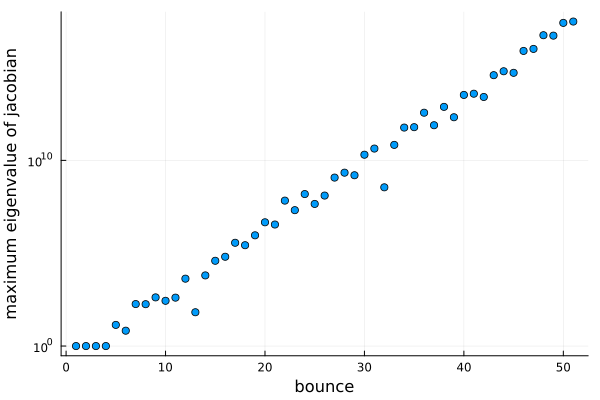

In [84]:
db= Billiard([Hwall(2),Hwall(-2),Vwall(2),Vwall(-2),Cwall(1)],
    Ball(dualxv(1.5,0.,1.,0.5)...,0.),[-2,-2,2,2])
ds=simulate(db,50);
jaclist=[jac(event) for event in ds.events]
eiglist=[eigvals(j) for j in jaclist]
scatter([maximum(abs.(e)) for e in eiglist],yscale=:log10,label="",
    xlabel="bounce",ylabel="maximum eigenvalue of jacobian") 

Apparently nearby trajectories diverge exponentially -- indicating chaos.